## Интеллектуальный анализ данных – весна 2023
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html).

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования.

In [ ]:
X.isnull().sum()
# в наборе данных нет пропущенных значений

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64

In [3]:
# для удобства работы с нашим датасетом создаем маску, указывающую на столбцы с категориальными признаками
# категориальные признаки имеют тип "object"
cat_features_mask = (X.dtypes == "object").values
print('Количество категориальных признаков: ', cat_features_mask.sum())
# в наборе данных категориальных переменных

Количество категориальных признаков:  0


**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

In [4]:
from sklearn.model_selection import train_test_split

In [6]:
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
22,13.71,1.86,2.36,16.6,101.0,2.61,2.88,0.27,1.69,3.80,1.11,4.00,1035.0
108,12.22,1.29,1.94,19.0,92.0,2.36,2.04,0.39,2.08,2.70,0.86,3.02,312.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
145,13.16,3.57,2.15,21.0,102.0,1.50,0.55,0.43,1.30,4.00,0.60,1.68,830.0
71,13.86,1.51,2.67,25.0,86.0,2.95,2.86,0.21,1.87,3.38,1.36,3.16,410.0


**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, **отличающихся только числом соседей**. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [ ]:
# пример вывода

### ПРИМЕР ВЫВОДА ###
NN 	 Train 	 Test
1 	 1.0 	 0.56
3 	 0.83 	 0.61
5 	 0.81 	 0.63
10 	 0.79 	 0.54
15 	 0.74 	 0.57
25 	 0.76 	 0.56


In [ ]:
# масштабируем признаки
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train[["alcohol",'magnesium']]))
X_test_norm = pd.DataFrame(scaler.transform(X_test[["alcohol",'magnesium']]))

In [ ]:
print("NN", "   Train", "   Test")
for k in [1, 3, 5, 10, 15, 25]:
  best_model = KNeighborsClassifier(n_neighbors=k, metric='euclidean').fit(X_train_norm, y_train)

  score_train = best_model.score(X_train_norm, y_train)
  score_test = best_model.score(X_test_norm, y_test)

  print('{:<5} {:<8} {:<8}'.format(k, round(score_train, 2), round(score_test, 2)))

NN    Train    Test
1     1.0      0.67    
3     0.81     0.78    
5     0.75     0.72    
10    0.73     0.78    
15    0.73     0.8     
25    0.67     0.8     


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

In [8]:
!pip install mlxtend --upgrade

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [9]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

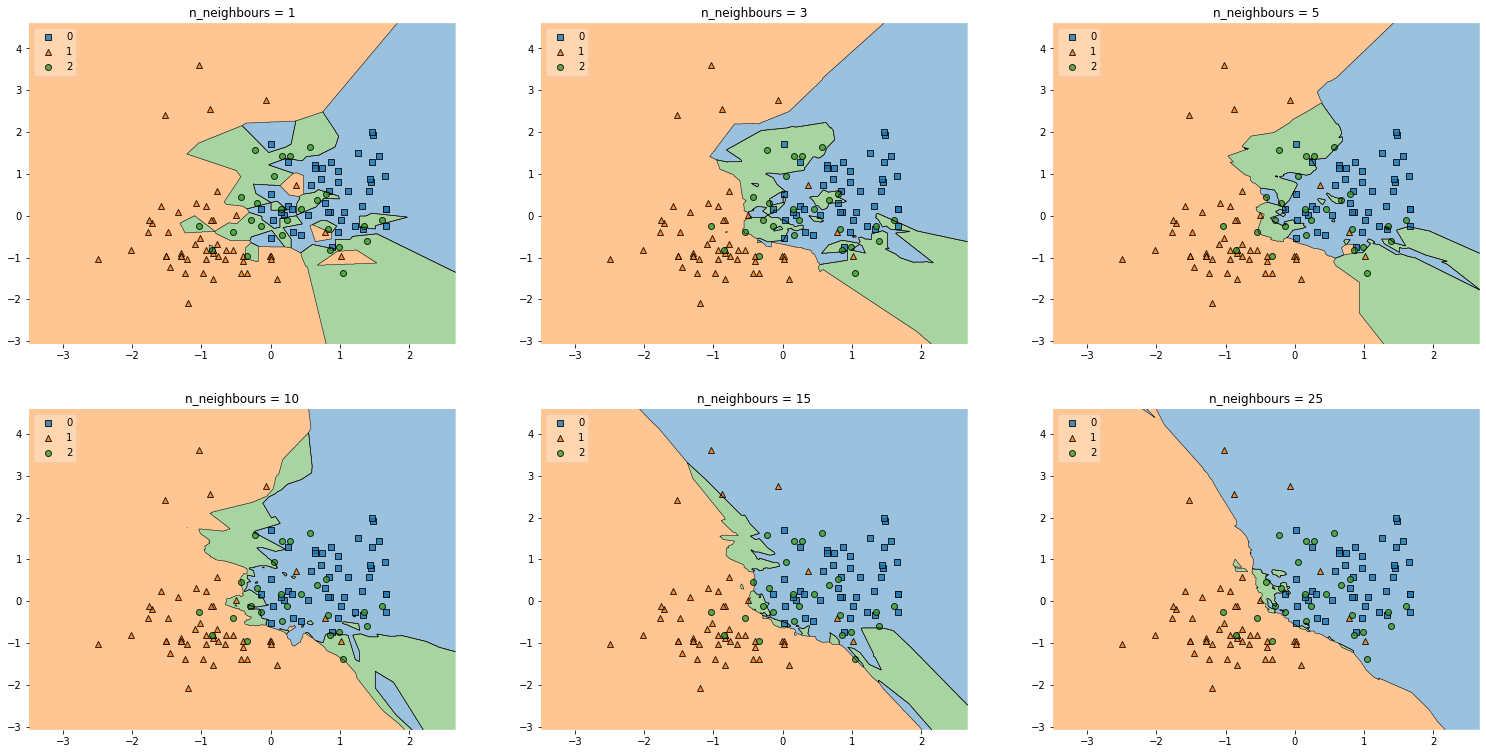

In [ ]:
# пример вывода

In [10]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
# Был использован готовый код, приведённый в документации, и далее адаптирован для заданного случая.

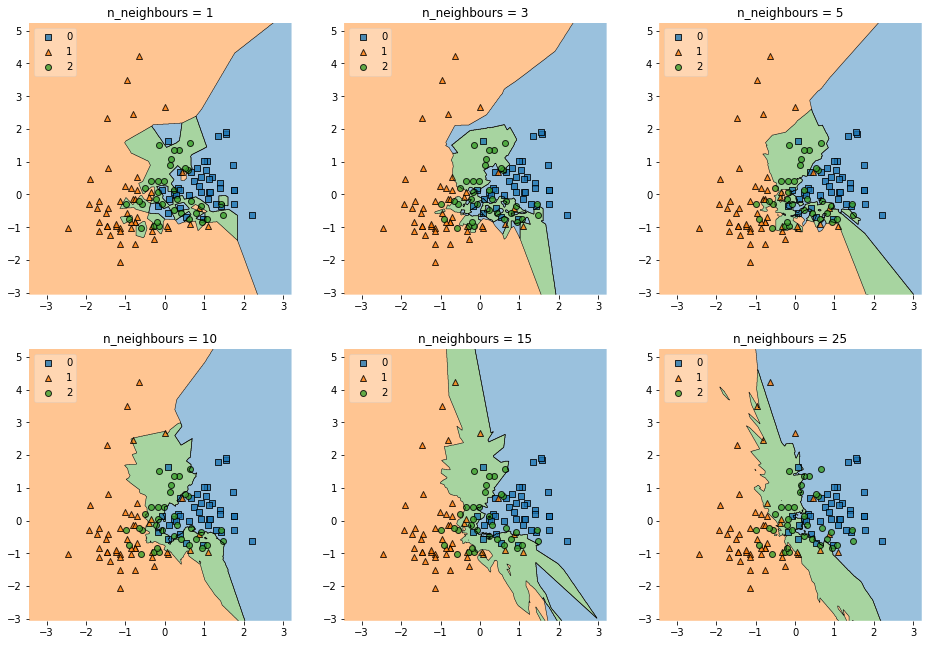

In [ ]:
clf1 = KNeighborsClassifier(n_neighbors=1, metric='euclidean').fit(X_train_norm, y_train)
clf2 = KNeighborsClassifier(n_neighbors=3, metric='euclidean').fit(X_train_norm, y_train)
clf3 = KNeighborsClassifier(n_neighbors=5, metric='euclidean').fit(X_train_norm, y_train)
clf4 = KNeighborsClassifier(n_neighbors=10, metric='euclidean').fit(X_train_norm, y_train)
clf5 = KNeighborsClassifier(n_neighbors=15, metric='euclidean').fit(X_train_norm, y_train)
clf6 = KNeighborsClassifier(n_neighbors=25, metric='euclidean').fit(X_train_norm, y_train)

gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(16,11))

labels = ['n_neighbours = 1', 'n_neighbours = 3', 'n_neighbours = 5', 'n_neighbours = 10', 'n_neighbours = 15', 'n_neighbours = 25']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                         labels,
                         itertools.product([0, 1, 2], repeat = 2)):
  ax = plt.subplot(gs[grd[0], grd[1]])
  fig = plot_decision_regions(X=X_train_norm.to_numpy(), y=y_train, clf=clf, legend=2)
  plt.title(lab)

plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности.

РЕЗУЛЬТАТ 1.3

**NN    Train    Test**

**1**   _  1.0   _   0.67    
**3**   _  0.81  _   0.78    
**5**   _  0.75  _   0.72    
**10** _  0.73  _   0.78    
**15**  _  0.73  _   0.8     
**25**  _  0.67  _   0.8

***Общий комментарий:***

k = 1 ; k = 3; k = 5

модель сильно подгоняется под данные, не ошибается на train и довольно много ошибается на test; также по полученной поверхности можно заметить, что модель сильно детализирует, разбивая поверхность в некоторых случая на "островки"

k = 10

модель явно стала лучше, тк ошибка на train увеличилась, а на test наоборото уменьшилась, однако она на граничных участках начинает подгоняться

k = 15

модель становится чуть лучше: при том что ошибка на train не изменилась, а на test уменьшилась, по поверхности можно сказать, что модель все же еще не идеальна (есть слабые острые моменты на стыке синей и зеленой части)  

**k = 25**

Я считаю, что эта самая хорошая модель  - ошибка на train возросла, а на test не изменилась, из чего можно сделать вывод о том, что модель явно лучше обучилась; по поверхности также заметно, что модель не подгоняется, лучше показывает себя на границах по сравнению со всеми другими

### Задание 2. KNN своими руками. 2 Балла

В данном задании мы попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

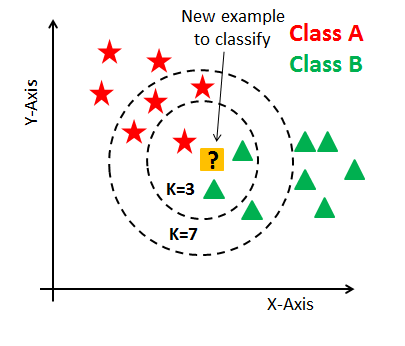

In [12]:
import numpy as np
from collections import Counter

class KNN:
    def __init__(self, k:int):
        self.k = k

    def fit(self, X, y):
      self.X_train = X
      self.y_train = y

    def predict(self, X):
      ans = []
      for i in range(len(X)):
        distances = np.linalg.norm(X[i]- self.X_train, axis=1)
        neigh = sorted(zip(distances, self.y_train))[:self.k]
        k_sort = list(zip(*neigh))[1]
        ans.append(max(Counter(k_sort)))
      return np.array(ans)

In [13]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [ ]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [15]:
data = pd.read_csv("https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2021/homeworks/hw04-knn_linreg/data/diamonds.csv")
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


***Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.***

**Задача 3.1 (0.1 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.

In [16]:
data.isnull().sum()
# в наборе данных нет пропущенных значений

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

**Задача 3.2 (0.1 балла)** Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [17]:
data = data.drop('Unnamed: 0', axis=1)
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**Задача 3.3 (0.1 балла)** Линейная регрессия основана на **предположении о линейной связи между признаками и целевой переменной**, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

<ipython-input-20-170bf9dbc89b>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap="crest", annot=True)


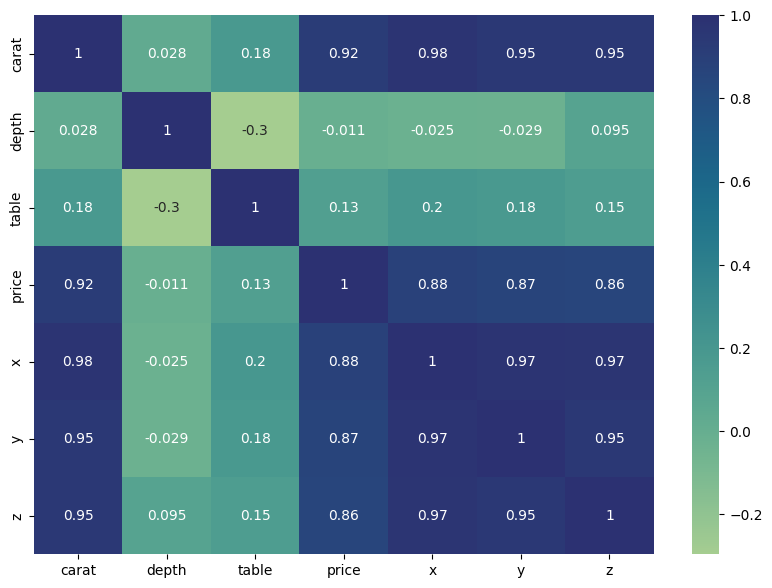

In [20]:
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(data.corr(), cmap="crest", annot=True)
plt.show()
# признаки carat(0.92), x(0.88), y(0.87), z(0.86) коррелируют с целевой price переменной больше всего

**Задача 3.4 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи **OneHot-кодирования**.

In [21]:
data = pd.get_dummies(data, columns=['cut', 'color', 'clarity'], drop_first = True)
data.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,0,0,...,0,0,1,0,0,1,0,0,0,0


**Задача 3.5 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3.

In [22]:
X = data.drop(['price'], axis = 1) # независимые переменные, влияющие на price бриллианта
y = data['price'] # зависимая переменная - price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.head(5)

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
37441,0.33,61.9,54.0,4.42,4.46,2.75,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
32249,0.31,62.2,54.0,4.38,4.40,2.73,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
47694,0.50,62.2,54.0,5.10,5.13,3.18,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
25564,1.62,63.2,56.0,7.54,7.43,4.73,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
12327,1.20,62.9,60.0,6.64,6.69,4.19,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0


**Задача 3.6 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [ ]:
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train[['carat', 'depth', 'table','x', 'y', 'z']]))
X_test_norm = pd.DataFrame(scaler.transform(X_test[['carat', 'depth', 'table','x', 'y', 'z']]))

X_train_merged = np.concatenate((
    X_train_norm,
    X_train.drop(['carat', 'depth', 'table', 'x', 'y', 'z'], axis=1).to_numpy()),
    axis=1)

X_test_merged = np.concatenate((
    X_test_norm,
    X_test.drop(['carat', 'depth', 'table', 'x', 'y', 'z'], axis=1).to_numpy()),
    axis=1)

**Задача 3.7 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
l_reg = LinearRegression().fit(X_train_merged, y_train)
print(f"MSE train: {mean_squared_error(y_train, l_reg.predict(X_train_merged))}")
print(f"MSE test: {mean_squared_error(y_test, l_reg.predict(X_test_merged))}")

MSE train: 1272129.0057430223
MSE test: 1287979.9093719118


**Задача 3.8 (0.2 балла)** Изучите документацию модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [ ]:
pd.DataFrame(data=l_reg.coef_, index=X.columns).sort_values(by=0, ascending=False)

,0
carat,5303.748049
clarity_IF,5298.496979
clarity_VVS1,4977.517118
clarity_VVS2,4918.016571
clarity_VS1,4539.555808
clarity_VS2,4222.887515
clarity_SI1,3637.934339
clarity_SI2,2667.167172
cut_Ideal,786.041708
cut_Premium,716.014266


Вещественные переменные, оценки коэффициентов которых по модулю **превышают** оценки прочих вещественных переменных:

1.   carat
2.   x







**Задача 3.9 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется ***Lasso-регрессией***.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется ***Ridge-регрессией***.

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [ ]:
from sklearn.linear_model import Lasso, Ridge

In [ ]:
lasso = Lasso(alpha=10).fit(X_train_merged, y_train)
ridge = Ridge(alpha=10).fit(X_train_merged, y_train)

In [ ]:
pd.DataFrame(data=lasso.coef_, index=X.columns).sort_values(by=0, ascending=False)

,0
carat,4758.852357
clarity_IF,1286.524742
clarity_VVS2,1161.602198
clarity_VVS1,1154.109148
clarity_VS1,812.897552
clarity_VS2,566.548748
cut_Ideal,158.813631
cut_Very Good,75.020100
cut_Premium,64.061335
color_F,-0.000000


In [ ]:
pd.DataFrame(data=ridge.coef_, index=X.columns).sort_values(by=0, ascending=False)

,0
carat,5255.687019
clarity_IF,4722.293548
clarity_VVS1,4423.866574
clarity_VVS2,4371.884100
clarity_VS1,3999.668254
clarity_VS2,3688.796690
clarity_SI1,3107.421370
clarity_SI2,2144.371052
cut_Ideal,813.862305
cut_Premium,739.951178


**Сильно ли уменьшились веса?** - Lasso-регрессия сильнее уменьшила веса в отличие от Ridge

**Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.** - В изначальной регрессии проблема мультиколлинеарности проявлялась сильно, что изначально отражалось на матрице корреляции

**Задача 3.10 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

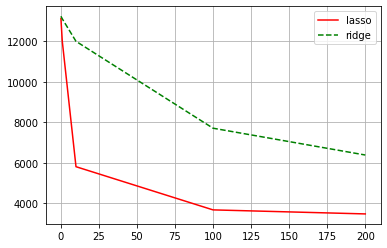

In [ ]:
lasso_graph = []
ridge_graph = []

for a in [0.1, 1, 10, 100, 200]:
    l = Lasso(alpha=a).fit(X_train_merged, y_train)
    r = Ridge(alpha=a).fit(X_train_merged, y_train)

    lasso_graph.append(np.linalg.norm(l.coef_))
    ridge_graph.append(np.linalg.norm(r.coef_))

plt.plot([0.1, 1, 10, 100, 200], lasso_graph, label="lasso", color='r')
plt.plot([0.1, 1, 10, 100, 200], ridge_graph, label="ridge", linestyle='--', color='g')
plt.grid()
plt.legend()



**Вывод по графику:**

 Lasso-регрессия агрессивнее уменьшает веса и помогает занулять менее значимые признаки, тем самым улучшая модель - понижая ее сложность

**Задача 3.11 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

In [ ]:
from sklearn.linear_model import LassoCV

In [ ]:
reg = LassoCV(alphas=[0.1, 1, 10, 100, 200], cv=5, random_state=np.random.seed(0)).fit(X_train_merged, y_train)
a = np.mean(reg.mse_path_, axis=1)
b = sorted(zip(a, reg.alphas_))
print("Oптимальное значение α =", b[0][1])

Oптимальное значение α = 0.1


**Задача 3.12 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [ ]:
lasso_result = Lasso(alpha=0.1).fit(X_train_merged, y_train)
lasso_result.coef_
pd.DataFrame(data=lasso_result.coef_, index=X.columns).sort_values(by=0, ascending=False)

# carat самый информативный признак, в то время как z оказался самым неинформативным

,0
carat,5298.284057
clarity_IF,5243.090148
clarity_VVS1,4924.079781
clarity_VVS2,4865.344752
clarity_VS1,4487.239549
clarity_VS2,4171.401320
clarity_SI1,3586.751872
clarity_SI2,2616.403483
cut_Ideal,776.249604
cut_Premium,706.083296


**Задача 3.13 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [ ]:
# 3.7 MSE TEST
l_reg = LinearRegression().fit(X_train_merged, y_train)
print(f"MSE test: {round(mean_squared_error(y_test, l_reg.predict(X_test_merged)), 2)}")

MSE test: 1287979.91


In [ ]:
lasso_result = Lasso(alpha=0.1).fit(X_train_merged, y_train)
prediction = lasso_result.predict(X_test_merged)
print(f"MSE test: {round(mean_squared_error(prediction, y_test), 2)}")

MSE test: 1288430.13


Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

- Лучше оказалась модель обычной линейная регрессии, тк она показала на тесте меньшую ошибку